In [22]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Social Network Analayis

In [27]:
# Load Data
sh_data = pd.read_csv('./Input_Data/Social/SH_Data.csv')
adjacency_matrix = pd.read_csv('./Input_Data/Social/Adjacency_matrix.csv', header=None)

In [28]:
# Rename columns in SH_Data
new_column_names = ["Actor", "Sector", "Factor","Role", "Level"]
sh_data.columns = new_column_names
sh_data.head()

,Actor,Sector,Factor,Role,Level
0,Land Owner-Forset Owners,Biomass,Forestry,Producer,Primary
1,Holiday Home Owners,Cross-Cutting,Cross-Cutting,Consumer,Primary
2,Residents,Cross-Cutting,Cross-Cutting,Consumer,Primary
3,Land Owner-Farmer,Biomass,Agriculture,Producer,Primary
4,Skjak Municpality,Cross-Cutting,Cross-Cutting,Coordination,Secondary


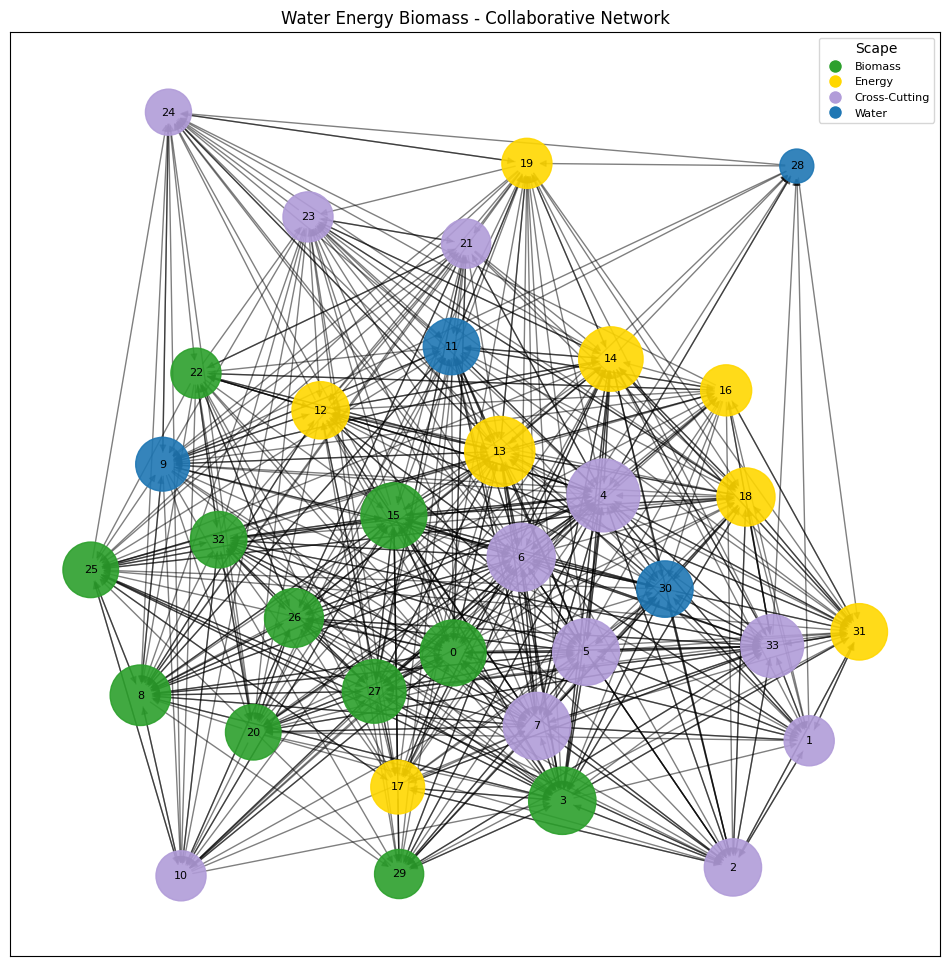

In [38]:
# Network from the adjacency matrix
G = nx.from_pandas_adjacency(adjacency_matrix, create_using=nx.DiGraph)

# Node attributes from SH_Data
sector_mapping = sh_data["Sector"].to_dict()
nx.set_node_attributes(G, sector_mapping, name="sector")

# Degree for node size | Node assignment based on sector
node_degrees = dict(G.degree())
sectors = list(set(sector_mapping.values()))
sector_colors = {sector: color for sector, color in zip(sectors, plt.cm.tab10.colors)}
sector_colors = {
    "Biomass": "#2CA02C",       # Green
    "Energy": "#FFD700",        # Yellow
    "Cross-Cutting": "#B19CD9", # Soft Purple
    "Water": "#1F77B4"          # Blue
}
# Visualization Attributes
node_sizes = [node_degrees[node] * 50 for node in G.nodes]
node_colors = [sector_colors[sector_mapping[node]] for node in G.nodes]


# Network Plot
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
# Legend Labels and Colors
legend_labels = {
    "Biomass": "#2CA02C",       # Green
    "Energy": "#FFD700",        # Yellow
    "Cross-Cutting": "#B19CD9", # Soft Purple
    "Water": "#1F77B4"          # Blue
}

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
    for label, color in legend_labels.items()
]
plt.legend(handles=legend_handles, loc='upper right', title="Scape", fontsize=8, title_fontsize=10)

plt.title("Water Energy Biomass - Collaborative Network")
plt.savefig("./Results/Collaborative_Network_plot.jpeg", dpi=300, bbox_inches='tight')
plt.show()


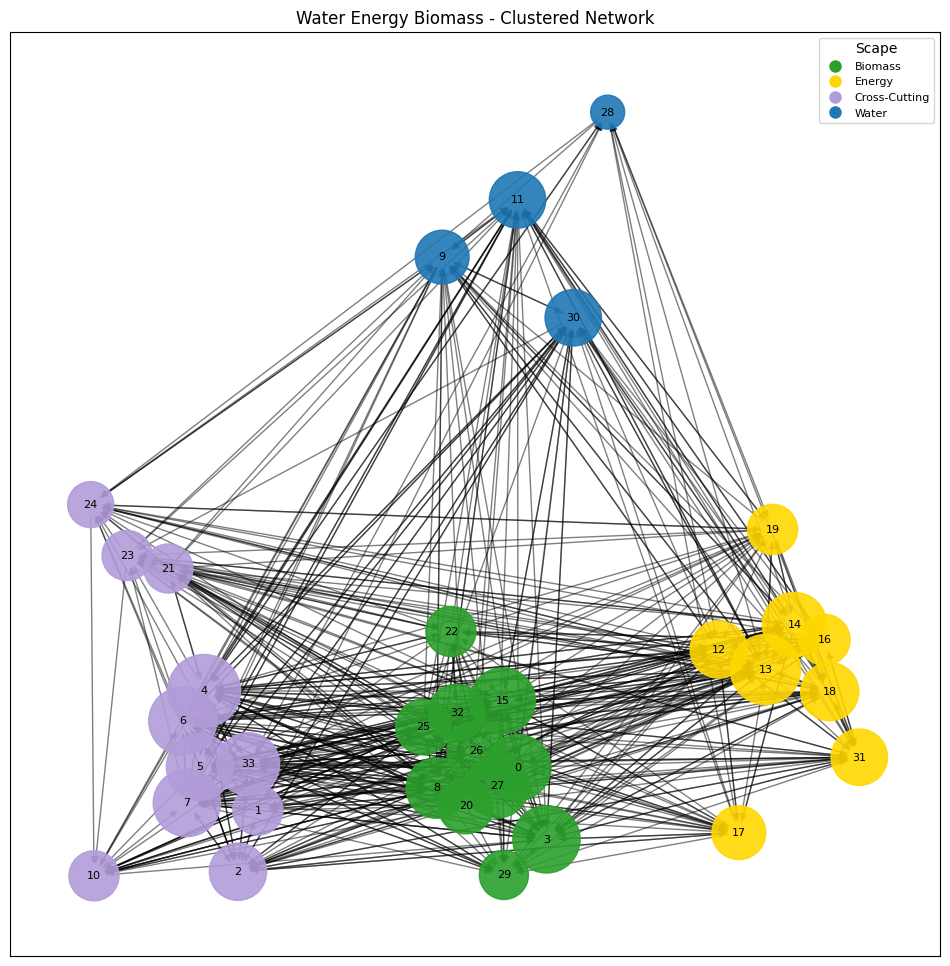

In [39]:
# Clusters based on scapes
sectors = list(set(sector_mapping.values()))  # Get sectors
clusters = {sector: [] for sector in sectors}  # Initialize cluster dictionary

for node, sector in sector_mapping.items():
    clusters[sector].append(node)

pos = nx.spring_layout(G, seed=42)  # Base layout

# Cluster separation
cluster_offsets = {
    sectors[0]: (0, 0), sectors[1]: (2, 0), sectors[2]: (-3, 0), sectors[3]: (0, 2)
}
cluster_positions = {}
for sector, nodes in clusters.items():
    offset = cluster_offsets.get(sector, (0, 0))
    for node in nodes:
        cluster_positions[node] = pos[node] + offset
sector_colors = {
    "Biomass": "#2CA02C",       # Green
    "Energy": "#FFD700",        # Yellow
    "Cross-Cutting": "#B19CD9", # Soft Purple
    "Water": "#1F77B4"          # Blue
}
# Clustered nodes plot
plt.figure(figsize=(12, 12))

for sector, color in sector_colors.items():
    nx.draw_networkx_nodes(
        G, cluster_positions, nodelist=clusters[sector],
        node_size=[node_degrees[node] * 50 for node in clusters[sector]],
        node_color=color, label=sector, alpha=0.9
    )

nx.draw_networkx_edges(G, cluster_positions, alpha=0.5, arrowsize=10)
nx.draw_networkx_labels(G, cluster_positions, font_size=8, font_color="black")
legend_labels = {
    "Biomass": "#2CA02C",       # Green
    "Energy": "#FFD700",        # Yellow
    "Cross-Cutting": "#B19CD9", # Soft Purple
    "Water": "#1F77B4"          # Blue
}

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
    for label, color in legend_labels.items()
]
plt.legend(handles=legend_handles, loc='upper right', title="Scape", fontsize=8, title_fontsize=10)

plt.title("Water Energy Biomass - Clustered Network")
plt.savefig("./Results/Network_Clusters_plot.jpeg", dpi=300, bbox_inches='tight')
plt.show()


In [40]:
# Sector EI Index and Overall Network EI Index
def calculate_ei_index(graph, sector_attribute):
    sectors = nx.get_node_attributes(graph, sector_attribute)
    ei_index_per_sector = {}
    total_external, total_internal = 0, 0
    
    for sector in set(sectors.values()):
        internal_links, external_links = 0, 0
        for node in graph.nodes:
            if sectors[node] == sector:
                for neighbor in graph[node]:
                    if sectors[neighbor] == sector:
                        internal_links += 1
                    else:
                        external_links += 1
        
        ei_index_per_sector[sector] = (external_links - internal_links) / (external_links + internal_links) if (external_links + internal_links) > 0 else 0
        total_external += external_links
        total_internal += internal_links

    overall_ei_index = (total_external - total_internal) / (total_external + total_internal) if (total_external + total_internal) > 0 else 0
    
    return ei_index_per_sector, overall_ei_index

# Compute EI indices
sector_ei_index, overall_ei_index = calculate_ei_index(G, "sector")
# Compute Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Print the results
output_file = "./Outputs/Social/SNA_results.txt"
# Save results to a text file
with open(output_file, "w") as file:
    # Print Sector EI Index
    print("Sector EI Index:", file=file)
    for sector, ei in sector_ei_index.items():
        print(f"  {sector}: {ei:.3f}", file=file)
    
    # Print Overall Network EI Index
    print(f"\nOverall Network EI Index: {overall_ei_index:.3f}", file=file)
    
    # Print Betweenness Centrality
    print("\nBetweenness Centrality:", file=file)
    for node, centrality in betweenness_centrality.items():
        print(f"  Node {node}: {centrality:.3f}", file=file)
# Print confirmation
print(f"Results saved to '{output_file}' successfully!")

Results saved to './Outputs/Social/SNA_results.txt' successfully!
